In [4]:
import cv2
from imutils import contours
import numpy as np
import matplotlib.pyplot as plt
import os
import operator
import tensorflow
import matplotlib.pyplot as plt

In [5]:
# 1) adaptive thresholding to highlight only numbers and grids
# 2)contouring and then use area parameter to supress numbers and highlight only grids
# 3) morphological closing to fix grid lines
# 4)iterarte over contours in each row and create mask for current contour; do a bitwise and to highlight only numbers


In [2]:
!pip install imutils

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25836 sha256=e0f2bd4860ee0cae18c3283c0fd8fd6ecc922ecda1127d20312f40ac0a8af02b
  Stored in directory: /home/snucse/.cache/pip/wheels/31/d0/2c/87ce38f6052879e5b7b18f0f8b4a10ad2a9d210e908d449f16
Successfully built imutils


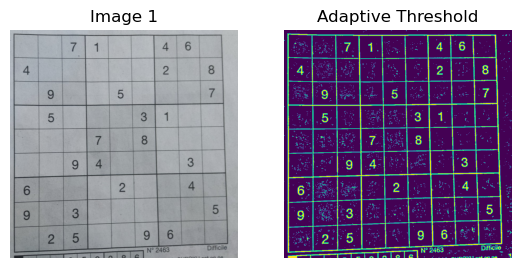

In [6]:
image = cv2.imread('Sudoku.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,57,5)


plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)  
plt.imshow(image)
plt.title('Image 1')
plt.axis('off')

plt.subplot(1, 3, 2)  
plt.imshow(thresh)
plt.title('Adaptive Threshold')
plt.axis('off')

plt.show()

In [7]:
import os

In [8]:
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 1000:
        cv2.drawContours(thresh, [c], -1, (0,0,0), -1)


vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, vertical_kernel, iterations=9)
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,1))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, horizontal_kernel, iterations=4)


invert = 255 - thresh
cnts = cv2.findContours(invert, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
(cnts, _) = contours.sort_contours(cnts, method="top-to-bottom")

sudoku_rows = []
row = []
for (i, c) in enumerate(cnts, 1):
    area = cv2.contourArea(c)
    if area < 50000:
        row.append(c)
        if i % 9 == 0:  
            (cnts, _) = contours.sort_contours(row, method="left-to-right")
            sudoku_rows.append(cnts)
            row = []
            
output_dir = 'output_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for idx, row in enumerate(sudoku_rows):
    for c_idx, c in enumerate(row):
        mask = np.zeros(image.shape, dtype=np.uint8)
        cv2.drawContours(mask, [c], -1, (255,255,255), -1)
        result = cv2.bitwise_and(image, mask)
        result[mask==0] = 255
        cv2.imwrite(os.path.join(output_dir, f'result_{idx}_{c_idx}.png'), result)
        cv2.waitKey(175)

cv2.imwrite(os.path.join(output_dir, 'thresh.png'), thresh)
cv2.imwrite(os.path.join(output_dir, 'invert.png'), invert)



True

In [9]:
import operator
import tensorflow

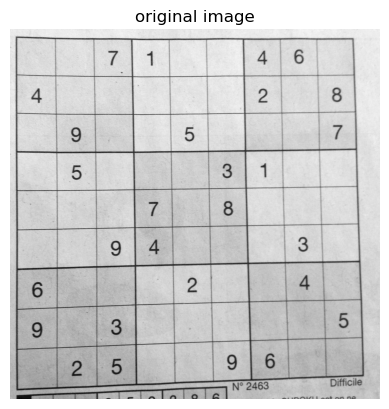

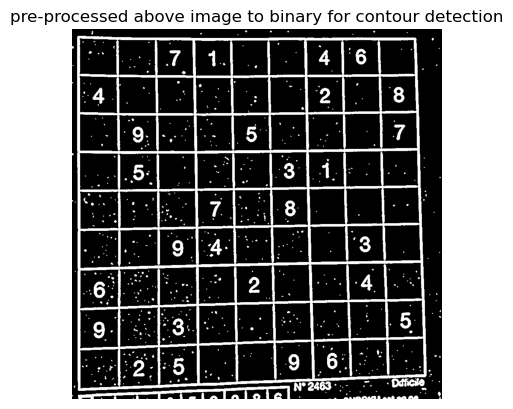

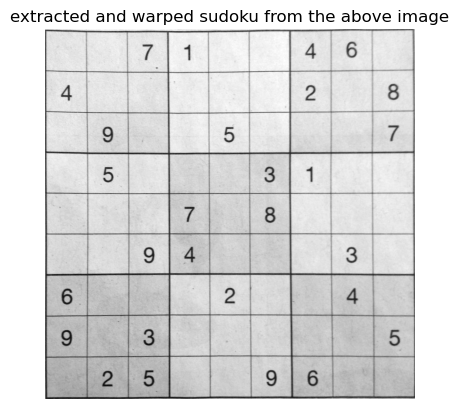

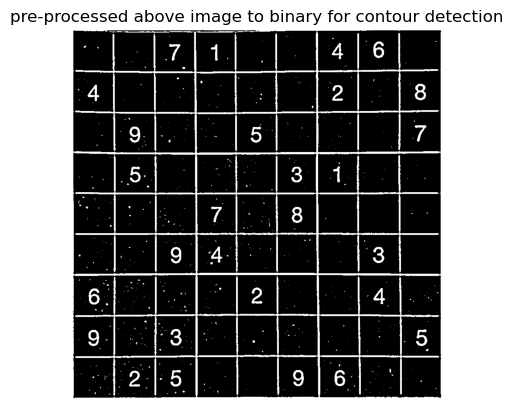

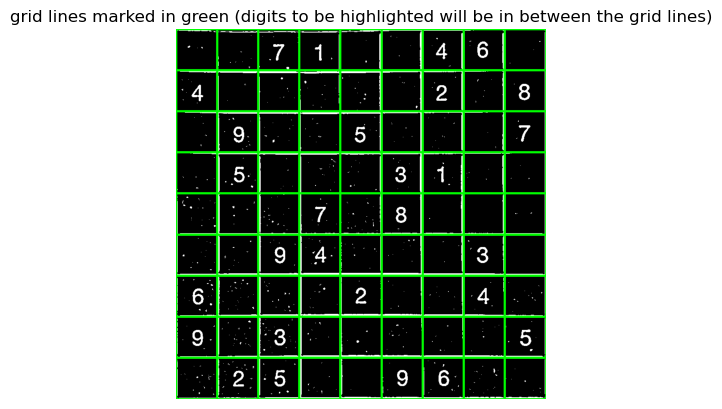

/tmp/ipykernel_25189/2399880301.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(rows, columns, i+1)


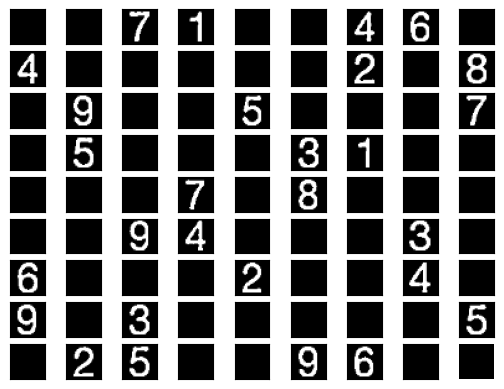

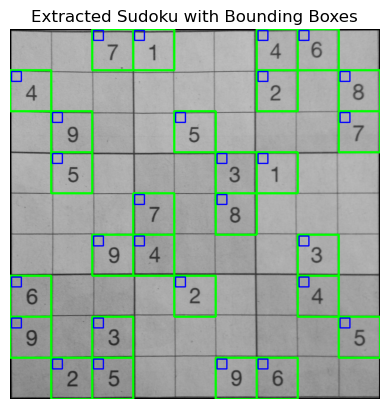

In [10]:
def plot_many_images(images, titles='', rows=9, columns=9):
    plt.title('Extracted elements from sudoku')
    for i, image in enumerate(images):
        plt.subplot(rows, columns, i+1)
        plt.imshow(image, 'gray')
        plt.xticks([]), plt.yticks([])
    plt.axis('off')
    plt.show()

def show_image(img, title='', flag=0):
    if flag != 0:
        return True
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def pre_process_image(img, skip_dilate=False, flag=0):
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    proc = cv2.bitwise_not(proc, proc)
    if not skip_dilate:
        kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
        proc = cv2.dilate(proc, kernel)
    show_image(proc, 'pre-processed above image to binary for contour detection', flag)
    return proc

def find_corners_of_largest_polygon(img):
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    polygon = contours[0]
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

def distance_between(p1, p2):
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))

def crop_and_warp(img, crop_rect, flag=0):
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
        ])
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
    m = cv2.getPerspectiveTransform(src, dst)
    warp = cv2.warpPerspective(img, m, (int(side), int(side)))
    show_image(warp, 'extracted and warped sudoku from the above image', flag)
    return warp

def infer_grid(img):
    squares = []
    side = img.shape[:1]
    side = side[0] / 9
    for j in range(9):
        for i in range(9):
            p1 = (i * side, j * side)
            p2 = ((i + 1) * side, (j + 1) * side)
            squares.append((p1, p2))
    return squares

def cut_from_rect(img, rect):
    return img[int(rect[0][1]):int(rect[1][1]), int(rect[0][0]):int(rect[1][0])]

def scale_and_centre(img, size, margin=0, background=0):
    h, w = img.shape[:2]
    def centre_pad(length):
        if length % 2 == 0:
            side1 = int((size - length) / 2)
            side2 = side1
        else:
            side1 = int((size - length) / 2)
            side2 = side1 + 1
        return side1, side2
    def scale(r, x):
        return int(r * x)
    if h > w:
        t_pad = int(margin / 2)
        b_pad = t_pad
        ratio = (size - margin) / h
        w, h = scale(ratio, w), scale(ratio, h)
        l_pad, r_pad = centre_pad(w)
    else:
        l_pad = int(margin / 2)
        r_pad = l_pad
        ratio = (size - margin) / w
        w, h = scale(ratio, w), scale(ratio, h)
        t_pad, b_pad = centre_pad(h)
    img = cv2.resize(img, (w, h))
    img = cv2.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv2.BORDER_CONSTANT, None, background)
    return cv2.resize(img, (size, size))

def find_largest_feature(inp_img, scan_tl=None, scan_br=None):
    img = inp_img.copy()
    height, width = img.shape[:2]
    max_area = 0
    seed_point = (None, None)
    if scan_tl is None:
        scan_tl = [0, 0]
    if scan_br is None:
        scan_br = [width, height]
    for x in range(scan_tl[0], scan_br[0]):
        for y in range(scan_tl[1], scan_br[1]):
            if img.item(y, x) == 255 and x < width and y < height:
                area = cv2.floodFill(img, None, (x, y), 64)
                if area[0] > max_area:
                    max_area = area[0]
                    seed_point = (x, y)
    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 255 and x < width and y < height:
                cv2.floodFill(img, None, (x, y), 64)
    mask = np.zeros((height + 2, width + 2), np.uint8)
    if all([p is not None for p in seed_point]):
        cv2.floodFill(img, mask, seed_point, 255)
    top, bottom, left, right = height, 0, width, 0
    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 64:
                cv2.floodFill(img, mask, (x, y), 0)
            if img.item(y, x) == 255:
                top = y if y < top else top
                bottom = y if y > bottom else bottom
                left = x if x < left else left
                right = x if x > right else right
    bbox = [[left, top], [right, bottom]]
    return img, np.array(bbox, dtype='float32'), seed_point

def extract_digit(img, rect, size):
    digit = cut_from_rect(img, rect)
    h, w = digit.shape[:2]
    margin = int(np.mean([h, w]) / 2.5)
    _, bbox, seed = find_largest_feature(digit, [margin, margin], [w - margin, h - margin])
    digit = cut_from_rect(digit, bbox)
    w = bbox[1][0] - bbox[0][0]
    h = bbox[1][1] - bbox[0][1]
    if w > 0 and h > 0 and (w * h) > 100 and len(digit) > 0:
        return scale_and_centre(digit, size, 4)
    else:
        return np.zeros((size, size), np.uint8)

def get_digits(img, squares, size, flag=0):
    digits = []
    img = pre_process_image(img.copy(), skip_dilate=True, flag=flag)
    ii = img.copy()
    ii = cv2.cvtColor(ii, cv2.COLOR_GRAY2BGR)
    for square in squares:
        digits.append(extract_digit(img, square, size))
        a, b = (int(square[0][0]), int(square[0][1])), (int(square[1][0]), int(square[1][1]))
        cv2.rectangle(ii, a, b, (0, 255, 0), 3)
    show_image(ii, 'grid lines marked in green (digits to be highlighted will be in between the grid lines)', flag)
    return digits

def parse_grid(path, flag=0):
    original = cv2.imread(path)
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    show_image(gray, 'original image', flag)
    processed = pre_process_image(gray, flag=flag)
    corners = find_corners_of_largest_polygon(processed)

    cropped = crop_and_warp(gray, corners, flag)
    cv2.rectangle(cropped, (0, 0), (cropped.shape[1], cropped.shape[0]), (0, 255, 0), 3)

    squares = infer_grid(cropped)
    digits = get_digits(cropped, squares, 28, flag=flag)
    warp_img = cv2.cvtColor(cropped.copy(), cv2.COLOR_BGR2RGB)

    # Draw bounding boxes only around cells with numbers and then around the numbers
    for digit, square in zip(digits, squares):
        if np.sum(digit) > 0:  # Check if the cell contains a number
            a, b = (int(square[0][0]), int(square[0][1])), (int(square[1][0]), int(square[1][1]))
            cv2.rectangle(warp_img, a, b, (0, 255, 0), 3)
            x, y = int(square[0][0]), int(square[0][1])
            cv2.rectangle(warp_img, (x+3, y+3), (x+25, y+25), (0, 0, 255), 2)  # Draw bounding box around number

    return digits, warp_img

path = 'Sudoku.jpg'
digits, sudoku_with_boxes = parse_grid(path, flag=0)
plot_many_images(digits)
show_image(sudoku_with_boxes, 'Extracted Sudoku with Bounding Boxes')


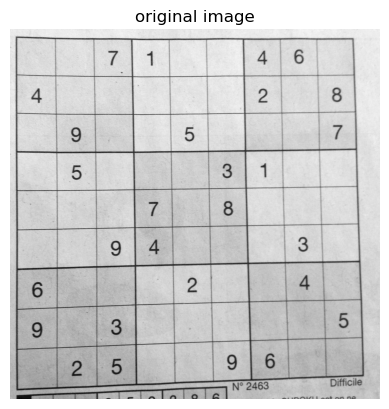

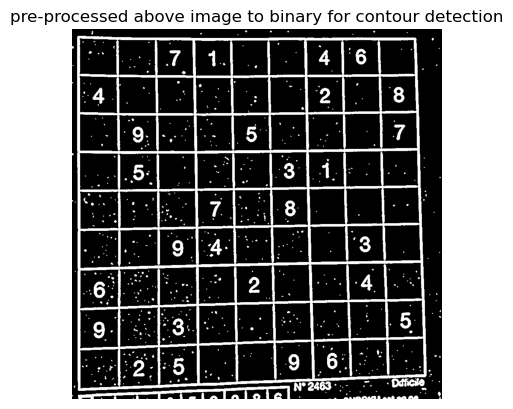

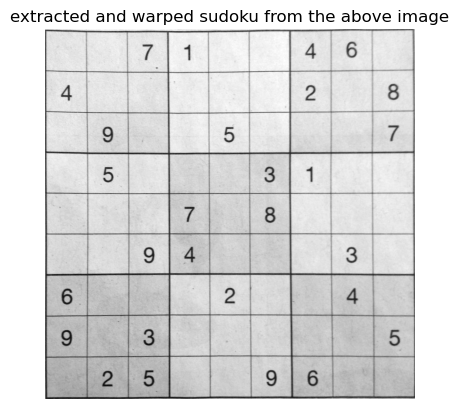

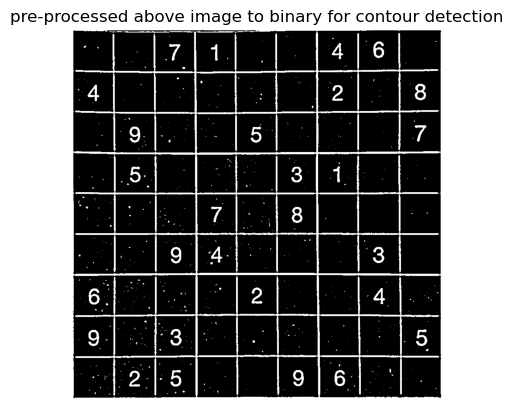

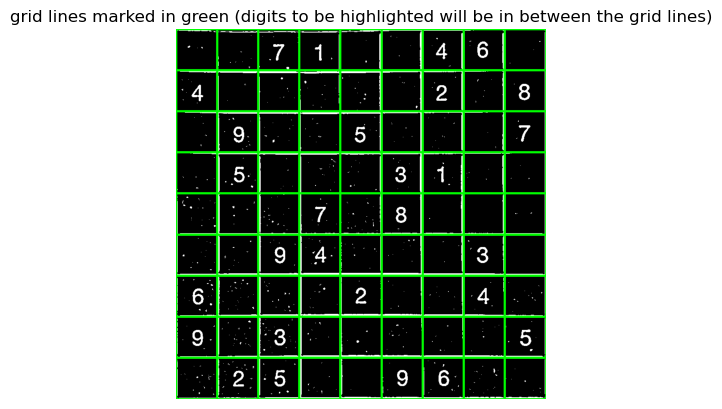

/tmp/ipykernel_25189/2907425307.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(rows, columns, i+1)


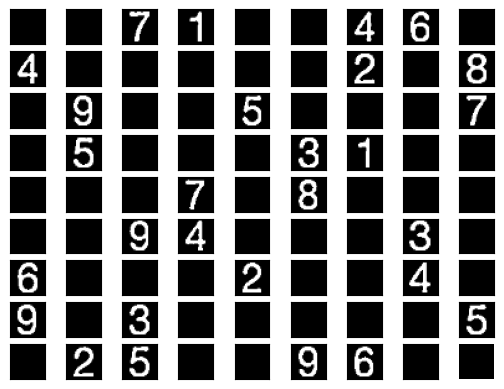

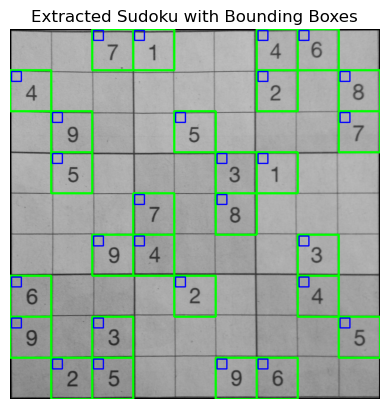

In [12]:
import os
import cv2
import pytesseract
import numpy as np
from tqdm import tqdm
import operator
import matplotlib.pyplot as plt

# Create output directory if it doesn't exist
output_dir = 'output_images'
os.makedirs(output_dir, exist_ok=True)

def plot_many_images(images, titles='', rows=9, columns=9, save_dir=None):
    plt.title('Extracted elements from sudoku')
    for i, image in enumerate(images):
        plt.subplot(rows, columns, i+1)
        plt.imshow(image, 'gray')
        plt.xticks([]), plt.yticks([])
        if save_dir:
            cv2.imwrite(os.path.join(save_dir, f"image_{i}.jpg"), image)
    plt.axis('off')
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'all_images_plot.png'))
    plt.show()

def show_image(img, title='', flag=0, save_path=None):
    if flag != 0:
        return True
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path)
    plt.show()

def pre_process_image(img, skip_dilate=False, flag=0, save_path=None):
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    proc = cv2.bitwise_not(proc, proc)
    if not skip_dilate:
        kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
        proc = cv2.dilate(proc, kernel)
    show_image(proc, 'pre-processed above image to binary for contour detection', flag, save_path)
    return proc

def find_corners_of_largest_polygon(img):
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    polygon = contours[0]
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

def distance_between(p1, p2):
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))

def crop_and_warp(img, crop_rect, flag=0, save_path=None):
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
        ])
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
    m = cv2.getPerspectiveTransform(src, dst)
    warp = cv2.warpPerspective(img, m, (int(side), int(side)))
    show_image(warp, 'extracted and warped sudoku from the above image', flag, save_path)
    return warp

def infer_grid(img):
    squares = []
    side = img.shape[:1]
    side = side[0] / 9
    for j in range(9):
        for i in range(9):
            p1 = (i * side, j * side)
            p2 = ((i + 1) * side, (j + 1) * side)
            squares.append((p1, p2))
    return squares

def cut_from_rect(img, rect):
    return img[int(rect[0][1]):int(rect[1][1]), int(rect[0][0]):int(rect[1][0])]

def scale_and_centre(img, size, margin=0, background=0):
    h, w = img.shape[:2]
    def centre_pad(length):
        if length % 2 == 0:
            side1 = int((size - length) / 2)
            side2 = side1
        else:
            side1 = int((size - length) / 2)
            side2 = side1 + 1
        return side1, side2
    def scale(r, x):
        return int(r * x)
    if h > w:
        t_pad = int(margin / 2)
        b_pad = t_pad
        ratio = (size - margin) / h
        w, h = scale(ratio, w), scale(ratio, h)
        l_pad, r_pad = centre_pad(w)
    else:
        l_pad = int(margin / 2)
        r_pad = l_pad
        ratio = (size - margin) / w
        w, h = scale(ratio, w), scale(ratio, h)
        t_pad, b_pad = centre_pad(h)
    img = cv2.resize(img, (w, h))
    img = cv2.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv2.BORDER_CONSTANT, None, background)
    return cv2.resize(img, (size, size))

def find_largest_feature(inp_img, scan_tl=None, scan_br=None):
    img = inp_img.copy()
    height, width = img.shape[:2]
    max_area = 0
    seed_point = (None, None)
    if scan_tl is None:
        scan_tl = [0, 0]
    if scan_br is None:
        scan_br = [width, height]
    for x in range(scan_tl[0], scan_br[0]):
        for y in range(scan_tl[1], scan_br[1]):
            if img.item(y, x) == 255 and x < width and y < height:
                area = cv2.floodFill(img, None, (x, y), 64)
                if area[0] > max_area:
                    max_area = area[0]
                    seed_point = (x, y)
    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 255 and x < width and y < height:
                cv2.floodFill(img, None, (x, y), 64)
    mask = np.zeros((height + 2, width + 2), np.uint8)
    if all([p is not None for p in seed_point]):
        cv2.floodFill(img, mask, seed_point, 255)
    top, bottom, left, right = height, 0, width, 0
    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 64:
                cv2.floodFill(img, mask, (x, y), 0)
            if img.item(y, x) == 255:
                top = y if y < top else top
                bottom = y if y > bottom else bottom
                left = x if x < left else left
                right = x if x > right else right
    bbox = [[left, top], [right, bottom]]
    return img, np.array(bbox, dtype='float32'), seed_point

def extract_digit(img, rect, size):
    digit = cut_from_rect(img, rect)
    h, w = digit.shape[:2]
    margin = int(np.mean([h, w]) / 2.5)
    _, bbox, seed = find_largest_feature(digit, [margin, margin], [w - margin, h - margin])
    digit = cut_from_rect(digit, bbox)
    w = bbox[1][0] - bbox[0][0]
    h = bbox[1][1] - bbox[0][1]
    if w > 0 and h > 0 and (w * h) > 100 and len(digit) > 0:
        return scale_and_centre(digit, size, 4)
    else:
        return np.zeros((size, size), np.uint8)

def get_digits(img, squares, size, flag=0, save_dir=None):
    digits = []
    img = pre_process_image(img.copy(), skip_dilate=True, flag=flag, save_path=os.path.join(save_dir, 'pre_processed_image.jpg'))
    ii = img.copy()
    ii = cv2.cvtColor(ii, cv2.COLOR_GRAY2BGR)
    for i, square in enumerate(squares):
        digits.append(extract_digit(img, square, size))
        a, b = (int(square[0][0]), int(square[0][1])), (int(square[1][0]), int(square[1][1]))
        cv2.rectangle(ii, a, b, (0, 255, 0), 3)
        cv2.imwrite(os.path.join(save_dir, f"digits_{i}.jpg"), digits[-1])
    show_image(ii, 'grid lines marked in green (digits to be highlighted will be in between the grid lines)', flag, os.path.join(save_dir, 'grid_lines_marked.jpg'))
    return digits

def parse_grid(path, flag=0, save_dir=None):
    original = cv2.imread(path)
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    show_image(gray, 'original image', flag, os.path.join(save_dir, 'original_image.jpg'))
    processed = pre_process_image(gray, flag=flag, save_path=os.path.join(save_dir, 'pre_processed_image.jpg'))
    corners = find_corners_of_largest_polygon(processed)

    cropped = crop_and_warp(gray, corners, flag, os.path.join(save_dir, 'cropped_and_warped_image.jpg'))
    cv2.rectangle(cropped, (0, 0), (cropped.shape[1], cropped.shape[0]), (0, 255, 0), 3)

    squares = infer_grid(cropped)
    digits = get_digits(cropped, squares, 28, flag, save_dir)
    warp_img = cv2.cvtColor(cropped.copy(), cv2.COLOR_BGR2RGB)

    # Draw bounding boxes only around cells with numbers and then around the numbers
    for i, (digit, square) in enumerate(zip(digits, squares)):
        if np.sum(digit) > 0:  # Check if the cell contains a number
            a, b = (int(square[0][0]), int(square[0][1])), (int(square[1][0]), int(square[1][1]))
            cv2.rectangle(warp_img, a, b, (0, 255, 0), 3)
            x, y = int(square[0][0]), int(square[0][1])
            cv2.rectangle(warp_img, (x+3, y+3), (x+25, y+25), (0, 0, 255), 2)  # Draw bounding box around number
            cv2.imwrite(os.path.join(save_dir, f"bounding_box_{i}.jpg"), warp_img[a[1]:b[1], a[0]:b[0]])

    return digits, warp_img

path = 'Sudoku.jpg'
save_dir = 'output_images'
digits, sudoku_with_boxes = parse_grid(path, flag=0, save_dir=save_dir)
plot_many_images(digits, save_dir=save_dir)
show_image(sudoku_with_boxes, 'Extracted Sudoku with Bounding Boxes', save_path=os.path.join(save_dir, 'sudoku_with_boxes.jpg'))
